In [1]:
import tensorflow_hub as hub
import tensorflow as tf
import scipy.io as scio
import numpy as np
import time
import math
from numpy import linalg as LA
from scipy import signal
from scipy.signal import lfilter
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
# Publisher
import socket
import threading
import json
import nltk
from nltk import tokenize

In [2]:
model_path = '../2'

#Latent dimensions
latent_dim = 20

# Load mean pose
init_pose = scio.loadmat('../Data/mean_pose.mat')['mean_vector']
init_pose = np.transpose(init_pose,(1,0))
init_input = tf.tile(tf.expand_dims(init_pose, axis=0), [1, 1, 1])
print(init_input.shape)

(1, 1, 24)


In [3]:
#Load the model
def load_encoder(model_path):
    #Output's dimension = 512
    encoder = hub.load(model_path)
    return encoder

encoder = load_encoder(model_path)
generator = tf.keras.models.load_model('../Models/model_epoch_150.keras')

In [4]:
# Input: (24, time_seq)
# Output: (8, 3, time_seq)
def construct_joint3D(plot_vec):
    plot_vec = np.reshape(plot_vec, [8, 3, -1])

    mean_len = [0.6, 0.7, 0.9, 0.9, 0.7, 0.9, 0.9]

    plot_pose = np.zeros(plot_vec.shape)
    plot_pose[1, :, :] = plot_vec[0, :, :];
    plot_pose[0, :, :] = plot_pose[1, :, :]+\
                         mean_len[0] * np.divide(plot_vec[1, :, :], 
                                                 np.tile(np.linalg.norm(plot_vec[1, :, :], axis=0), (3, 1)))
    plot_pose[2, :, :] = plot_pose[1, :, :]+\
                         mean_len[1] * np.divide(plot_vec[2, :, :], 
                                                 np.tile(np.linalg.norm(plot_vec[2, :, :], axis=0), (3, 1)))
    plot_pose[3, :, :] = plot_pose[2, :, :]+\
                         mean_len[2] * np.divide(plot_vec[3, :, :], 
                                                 np.tile(np.linalg.norm(plot_vec[3, :, :], axis=0), (3, 1)))
    plot_pose[4, :, :] = plot_pose[3, :, :]+\
                         mean_len[3] * np.divide(plot_vec[4, :, :], 
                                                 np.tile(np.linalg.norm(plot_vec[4, :, :], axis=0), (3, 1)))
    plot_pose[5, :, :] = plot_pose[1, :, :]+\
                         mean_len[4] * np.divide(plot_vec[5, :, :], 
                                                 np.tile(np.linalg.norm(plot_vec[5, :, :], axis=0), (3, 1)))
    plot_pose[6, :, :] = plot_pose[5, :, :]+\
                         mean_len[5] * np.divide(plot_vec[6, :, :], 
                                                 np.tile(np.linalg.norm(plot_vec[6, :, :], axis=0), (3, 1)))
    plot_pose[7, :, :] = plot_pose[6, :, :]+\
                         mean_len[6] * np.divide(plot_vec[7, :, :], 
                                                 np.tile(np.linalg.norm(plot_vec[7, :, :], axis=0), (3, 1)))
    return plot_pose

In [5]:
def draw_mot(plot_pose, epochs, Action):
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    ax = fig.add_subplot(111, projection='3d')
    
    # Function to update each frame of the animation
    def update(i):
        ax.clear()

        ax.grid(False)
        ax.set_facecolor('white')
        
        # Plotting the lines and points for the current frame
        ax.plot(plot_pose[0:2, 0, i], plot_pose[0:2, 1, i], plot_pose[0:2, 2, i], c='black')
        ax.plot(plot_pose[1:3, 0, i], plot_pose[1:3, 1, i], plot_pose[1:3, 2, i], c='black')
        ax.plot(plot_pose[2:4, 0, i], plot_pose[2:4, 1, i], plot_pose[2:4, 2, i], c='black')
        ax.plot(plot_pose[3:5, 0, i], plot_pose[3:5, 1, i], plot_pose[3:5, 2, i], c='black')
        ax.plot(plot_pose[1:6:4, 0, i], plot_pose[1:6:4, 1, i], plot_pose[1:6:4, 2, i], c='black')
        ax.plot(plot_pose[5:7, 0, i], plot_pose[5:7, 1, i], plot_pose[5:7, 2, i], c='black')
        ax.plot(plot_pose[6:8, 0, i], plot_pose[6:8, 1, i], plot_pose[6:8, 2, i], c='black')

        ax.scatter(plot_pose[:, 0, i], plot_pose[:, 1, i], plot_pose[:, 2, i], c='black')

        # Setting axes properties
        ax.set_xlim3d(-3, 3)
        ax.set_ylim3d(-3, 3)
        ax.set_zlim3d(-3, 3)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.view_init(azim=0, elev=0)
        ax.set_title(f'{i} Model_{epochs}, {Action}')

    # Create an animation
    ani = animation.FuncAnimation(fig, update, frames=plot_pose.shape[2], repeat=False)

    # Display animation in Jupyter Notebook
    return HTML(ani.to_jshtml())

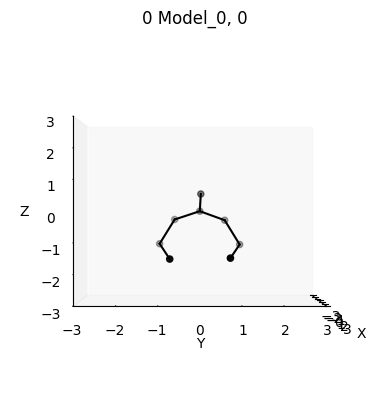

In [6]:
pose = construct_joint3D(init_pose)
HTML_output = draw_mot(pose, 0, 0)
HTML_output

In [7]:
# Create an Publisher
class NotebookPublisher:
    def __init__(self, host='localhost', port=5000):
        self.host = host
        self.port = port
        self.clients = []
        self.lock = threading.Lock()
        
        # Start server thread
        self.server_thread = threading.Thread(target=self._run_server, daemon=True)
        self.server_thread.start()
        print(f"[Notebook] Publisher started at {host}:{port}")

    def _run_server(self):
        with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
            s.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
            s.bind((self.host, self.port))
            s.listen()
            
            while True:
                conn, addr = s.accept()
                with self.lock:
                    self.clients.append(conn)
                print(f"[Notebook] Subscriber connected: {addr}")

    def send_motion(self, motion_data, text=" "):
        """Send motion data to all Python 2 subscribers"""
        if not isinstance(motion_data, list):
            motion_data = motion_data.tolist()  # Convert numpy arrays
            
        msg = {"type": "motion", 
               "data": motion_data,
               "text": text}
        
        msg_json = json.dumps(msg).encode('utf-8')
        with self.lock:
            to_remove = []
            for i, client in enumerate(self.clients):
                try:
                    client.sendall(msg_json)
                except (BrokenPipeError, ConnectionResetError):
                    to_remove.append(i)
                    client.close()
            
            # Cleanup disconnected clients
            for idx in reversed(to_remove):
                del self.clients[idx]

In [8]:
min = -0.13500924408435822
max = 0.1370220184326172

# Normalize action data
def normalize_data(data, data_min, data_max):
    return 2 * ((data - data_min) / (data_max - data_min)) - 1

# Input: raw text
# Output: (time_seq, 24) 
def gen_t2a(test_script, init_pose):

    text_embeddings = encoder([test_script])
    test_script_normalize = normalize_data(text_embeddings, min, max)

    noise = tf.random.normal([1,latent_dim])
    generated_motion = generator.predict([noise,test_script_normalize,init_pose])

    return generated_motion

In [9]:
def split_text(text):
    return tokenize.sent_tokenize(text)

In [10]:
# Initialize Publisher
motion_publisher = NotebookPublisher()

[Notebook] Publisher started at localhost:5000


[Notebook] Subscriber connected: ('127.0.0.1', 51397)
[Notebook] Subscriber connected: ('127.0.0.1', 51426)
[Notebook] Subscriber connected: ('127.0.0.1', 51488)
[Notebook] Subscriber connected: ('127.0.0.1', 51507)
[Notebook] Subscriber connected: ('127.0.0.1', 51820)
[Notebook] Subscriber connected: ('127.0.0.1', 51933)
[Notebook] Subscriber connected: ('127.0.0.1', 51951)
[Notebook] Subscriber connected: ('127.0.0.1', 51979)
[Notebook] Subscriber connected: ('127.0.0.1', 51995)
[Notebook] Subscriber connected: ('127.0.0.1', 52175)
[Notebook] Subscriber connected: ('127.0.0.1', 52199)
[Notebook] Subscriber connected: ('127.0.0.1', 52221)


In [11]:
# Test Script Option
# A man is dancing in the ballet. #
# a woman preparing some recipe #
# a guy is dancing with a woman
# a woman is talking
# An old man is singing on stage #
# a musician on stage performing
# a man performs a dance sequence
# woman works in the kitchen to make a delicious meal
# A woman is exercising in the gym room #
# girl walking towards a guy
# a man checking a car #
# a man is reading a children book to children #
# a woman cannot stop laughing #
# a man does funny leg movements while on a running track #

In [12]:
def send_paragraph(paragraph):
    sentences = split_text(paragraph)
    current_motion = init_input
    output_skel_array = []
    for sentences in sentences:
        first_mot = gen_t2a(test_script= sentences, init_pose= current_motion)
        first_mot_transpose = np.transpose(first_mot, (0,2,1))
        output_skel = construct_joint3D(first_mot_transpose)
        output_skel_array.append(output_skel)
        motion_publisher.send_motion(output_skel, sentences)

        # Get the last motion
        last_motion = first_mot_transpose[-1]
        current_motion = last_motion.reshape(1,-1)
        current_motion = tf.tile(tf.expand_dims(current_motion, axis=0), [1, 1, 1])
        time.sleep(4.5)

    continuous_motion = np.concatenate(output_skel_array, axis =2)
    print(continuous_motion.shape)
    print(type(continuous_motion))
    return continuous_motion

In [13]:
paragraph = 'In a bustling city, a man is dancing gracefully in the ballet studio, his movements precise and fluid. ' \
'Meanwhile, in a cozy kitchen, a woman is preparing some recipe, ' \
'carefully measuring ingredients as steam rises from a pot. ' \
'Across town, an old man is singing soulfully on stage, his voice echoing through the auditorium. ' \
'Nearby, another woman is exercising vigorously in the gym room, her focus unbroken by the clatter of weights. ' \
'At the local library, a man is reading a book to a captivated group of kids, his animated voices drawing giggles. ' \
'In a park, a woman cannot stop laughing at a joke, clutching her sides in delight. ' \
'Finally, on a sunlit running track, a man does funny leg movements, ' \
'hopping and twisting mid-stride, drawing curious glances from joggers.'

continuous_motion = send_paragraph(paragraph = paragraph)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


KeyboardInterrupt: 

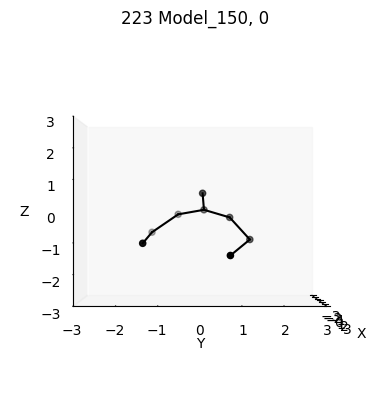

In [31]:
HTML_output = draw_mot(continuous_motion, 150, 0)
HTML_output

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


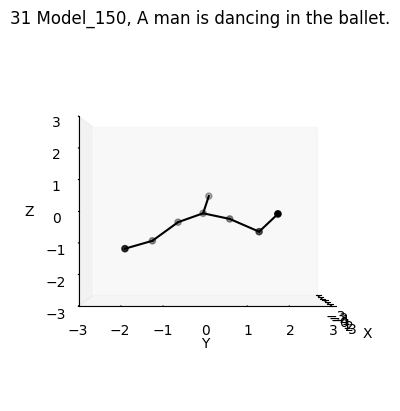

In [29]:
#A man is dancing in the ballet.
#An old man is singing on stage

test_script = 'A man is dancing in the ballet.'  #1503
first_mot = gen_t2a(test_script = test_script, init_pose = init_input)
first_mot_transpose = np.transpose(first_mot, (0,2,1))
output_skel = construct_joint3D(first_mot_transpose)
HTML_output = draw_mot(output_skel, 150, test_script)
HTML_output

In [38]:
###################Publisher####################

# Send to Python 2 subscriber
motion_publisher.send_motion(output_skel, test_script)

(24, 32)


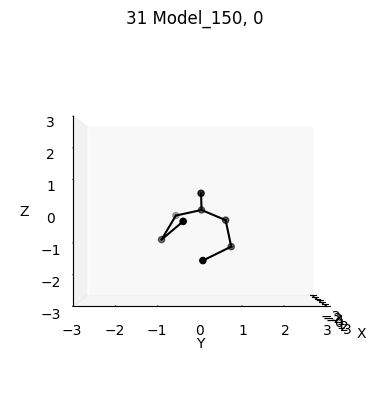

In [21]:
# Ground truth motion
ground_truth_motion = np.load('../Data/test_action.npy')
ground_truth_motion = np.transpose(ground_truth_motion[4648], (1,0))
print(ground_truth_motion.shape)

output_skel = construct_joint3D(ground_truth_motion)
HTML_output = draw_mot(output_skel, 150, 0)
HTML_output
